# Predicting Crime - Time Series Forecasting

## Import Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

## Import Data

In [7]:
# Import Data - Skipping Bad lines that are badly formatted
chicago_df_1 = pd.read_csv('./datasets/Chicago_Crimes_2005_to_2007.csv', on_bad_lines='skip')
chicago_df_2 = pd.read_csv('./datasets/Chicago_Crimes_2008_to_2011.csv', on_bad_lines='skip')
chicago_df_3 = pd.read_csv('./datasets/Chicago_Crimes_2012_to_2017.csv', on_bad_lines='skip')

In [8]:
# Concatenate Dataframes into a single one
chicago_df = pd.concat([chicago_df_1, chicago_df_2, chicago_df_3])
del chicago_df_1
del chicago_df_2
del chicago_df_3

## Visualize Data

In [14]:
# Display Head of chicago_df
chicago_df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"


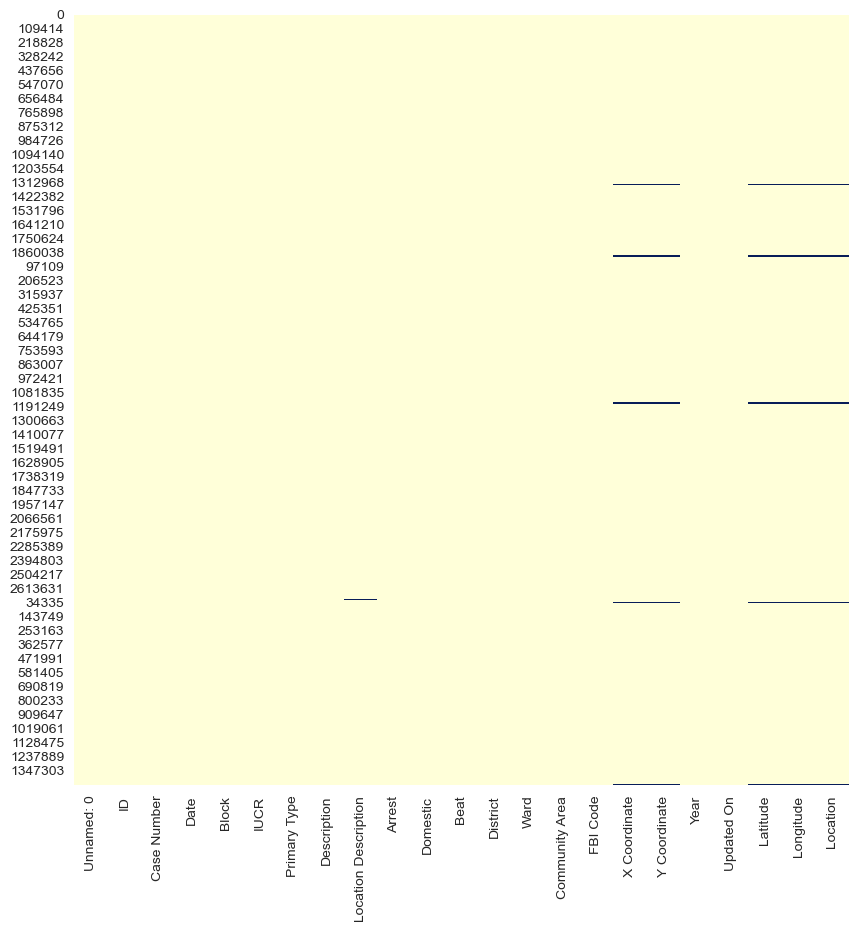

In [15]:
# Plotting Missing Data-Set
plt.figure(figsize=(10,10))
sns.heatmap(chicago_df.isnull(), cbar=False, cmap='YlGnBu')
plt.show()

In [16]:
# Drop the Columns we don't need or that have nulls
chicago_df_filtered = chicago_df.drop(['Unnamed: 0','Case Number','ID','IUCR','X Coordinate','Y Coordinate','Updated On','Year','FBI Code','Beat','Ward','Community Area','Location','District','Latitude','Longitude'],axis=1)
del chicago_df

In [18]:
# Re-arrange Date Column into date tame
chicago_df_filtered.Date = pd.to_datetime(chicago_df_filtered.Date, format='%m/%d/%Y %I:%M:%S %p')

In [28]:
# Select Date as the Index
chicago_df_filtered.index = pd.DatetimeIndex(chicago_df_filtered.Date)

In [29]:
# Extract Count of Types of Crimes (First 15 samples)
print(chicago_df_filtered['Primary Type'].value_counts().iloc[:15])

print('-----------------------------------------------')
# Get the Dataframe index to extract them
primary_type_top_index = chicago_df_filtered['Primary Type'].value_counts().iloc[:15].index
print(primary_type_top_index)

THEFT                         1245111
BATTERY                       1079178
CRIMINAL DAMAGE                702702
NARCOTICS                      674831
BURGLARY                       369056
OTHER OFFENSE                  368169
ASSAULT                        360244
MOTOR VEHICLE THEFT            271624
ROBBERY                        229467
DECEPTIVE PRACTICE             225180
CRIMINAL TRESPASS              171596
PROSTITUTION                    60735
WEAPONS VIOLATION               60335
PUBLIC PEACE VIOLATION          48403
OFFENSE INVOLVING CHILDREN      40260
Name: Primary Type, dtype: int64
-----------------------------------------------
Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'OTHER OFFENSE', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object')


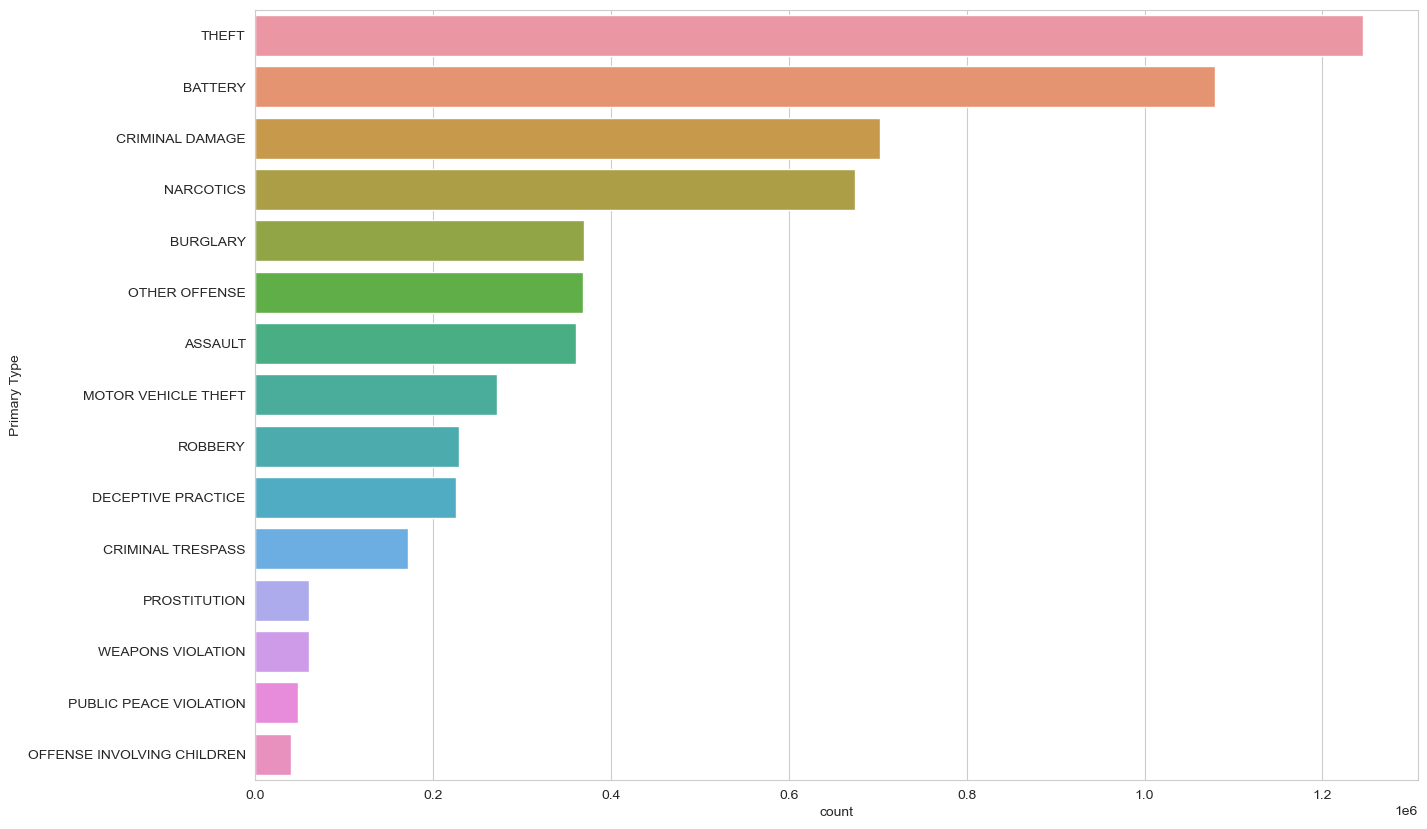

In [30]:
# Plot The Counts per Primary Crime Type
plt.figure(figsize=(15,10))
sns.countplot(y='Primary Type', data=chicago_df_filtered, order=primary_type_top_index)
plt.show()

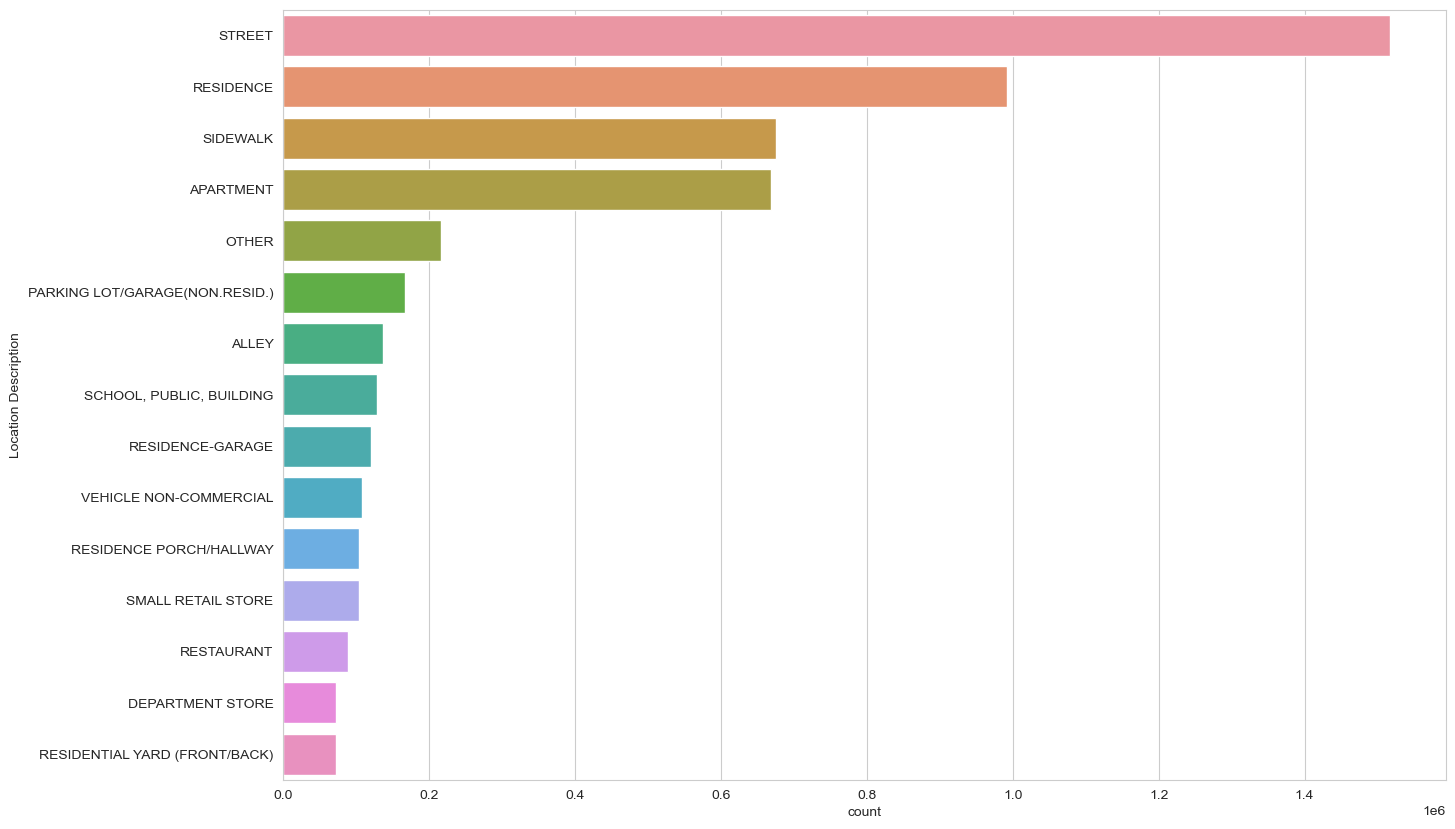

In [31]:
# Plot The Counts of the Location of the Crimes
location_description_top_index = chicago_df_filtered['Location Description'].value_counts().iloc[:15].index
plt.figure(figsize=(15,10))
sns.countplot(y='Location Description', data=chicago_df_filtered, order=location_description_top_index)
plt.show()

In [32]:
# Resample Based on the Year (Date is index in the table)
# To visualize the crimes per year
chicago_df_filtered.resample('Y').size()

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes')

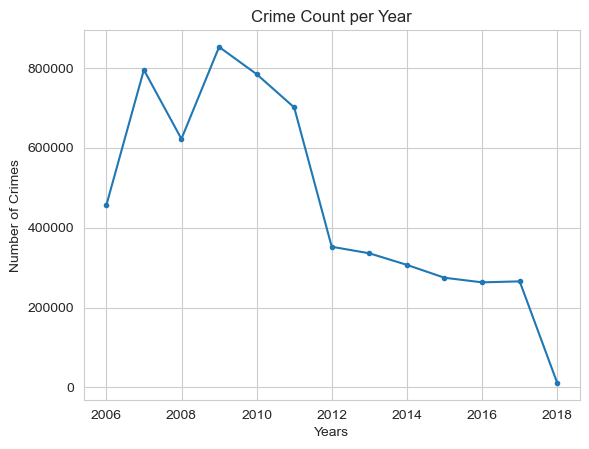

In [34]:
# Plot of Occurance per Year
plt.plot(chicago_df_filtered.resample('Y').size(), '.-')
plt.title('Crime Count per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

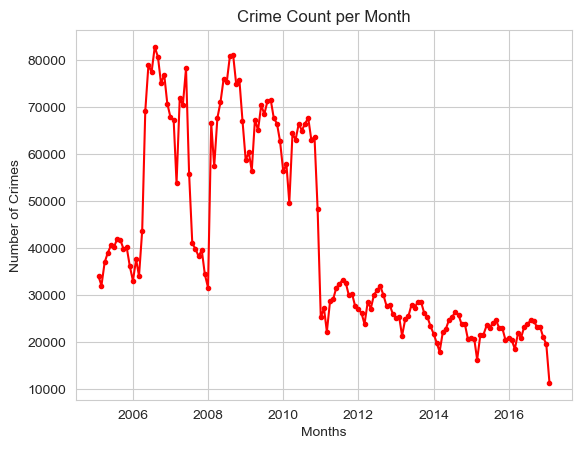

In [41]:
# Plot of Occurance per Month
plt.plot(chicago_df_filtered.resample('m').size(), 'r.-')
plt.title('Crime Count per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

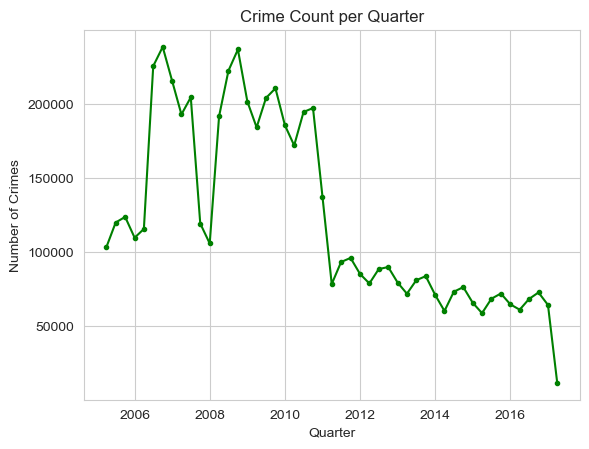

In [40]:
# Plot of Occurance per Quarter
plt.plot(chicago_df_filtered.resample('Q').size(), 'g.-')
plt.title('Crime Count per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Crimes')

## Data Preparation

In [42]:
# Assign the Time Information and Counts
chicago_prophet = chicago_df_filtered.resample('M').size().reset_index()
# Rename Columns
chicago_prophet.columns = ['Date','Crime Count']
# Show top 5 results
chicago_prophet.head()

,Date,Crime Count
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572


In [44]:
# Facebook Prophet requires Ds and Y as an input
chicago_prophet_renamed = chicago_prophet.rename(columns={'Date':'ds','Crime Count':'y'})

# Show Head with names changed
chicago_prophet_renamed.head()

,ds,y
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572


## Make Predictions through Facebook Prophet

In [47]:
meta = Prophet(weekly_seasonality=False, daily_seasonality=False) # Prophet Object
meta.fit(chicago_prophet_renamed)

In [50]:
# Do first prediction with Profet for the next 365 days
future = meta.make_future_dataframe(periods=365)
forecast = meta.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-31,60379.720403,39160.822382,72912.281434,60379.720403,60379.720403,-4888.559945,-4888.559945,-4888.559945,-4888.559945,-4888.559945,-4888.559945,0.0,0.0,0.0,55491.160458
1,2005-02-28,60249.704311,34410.461910,68446.286684,60249.704311,60249.704311,-9556.480896,-9556.480896,-9556.480896,-9556.480896,-9556.480896,-9556.480896,0.0,0.0,0.0,50693.223415
2,2005-03-31,60105.757924,42333.596402,75803.025371,60105.757924,60105.757924,-1267.695327,-1267.695327,-1267.695327,-1267.695327,-1267.695327,-1267.695327,0.0,0.0,0.0,58838.062597
3,2005-04-30,59966.454969,43262.952415,77096.265392,59966.454969,59966.454969,1143.949615,1143.949615,1143.949615,1143.949615,1143.949615,1143.949615,0.0,0.0,0.0,61110.404583
4,2005-05-31,59822.508582,49365.194237,82695.815741,59822.508582,59822.508582,5464.443944,5464.443944,5464.443944,5464.443944,5464.443944,5464.443944,0.0,0.0,0.0,65286.952525


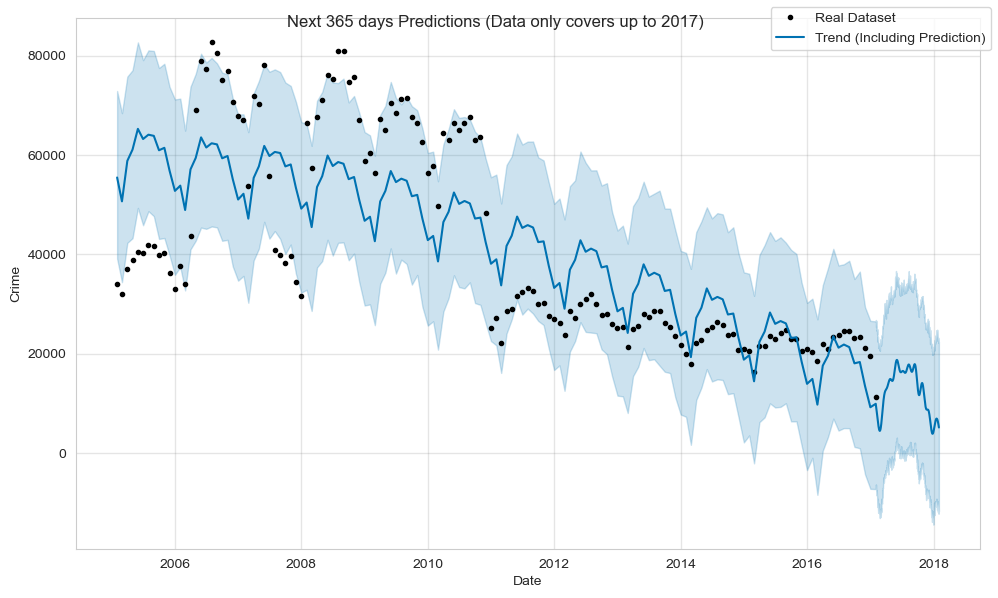

In [56]:
# Show forecast for Crime Rate based on the yearly prediction
figure = meta.plot(forecast, xlabel='Date', ylabel='Crime' )
figure.suptitle('2018 Predictions (Data only covers up to 2017)')
figure.legend(['Real Dataset','Trend (Including Prediction)'])

Text(0.5, 1.0, 'Predicted Year (2018) Seasonal Variations')

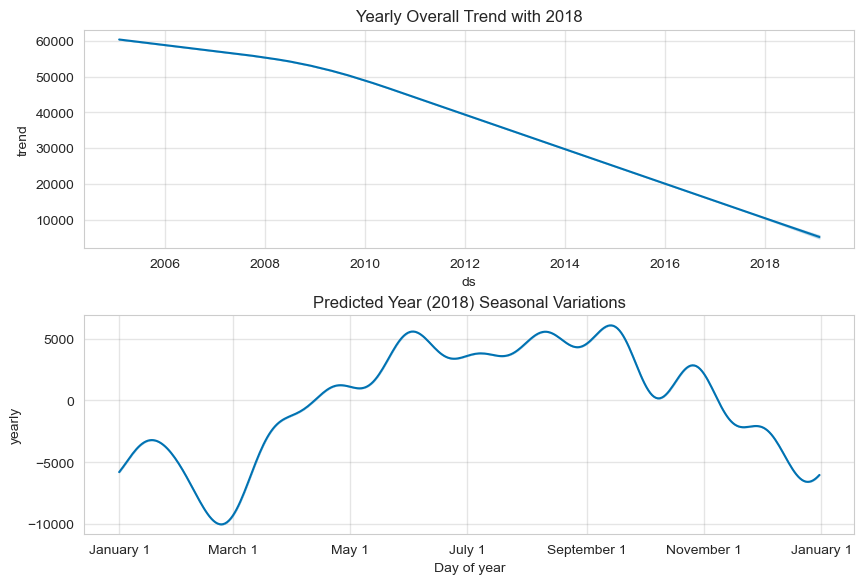

In [75]:
# Plot seasonality
figure = meta.plot_components(forecast)
figure.tight_layout(pad=2)
ax_list = figure.axes
ax_list[0].set_title('Yearly Overall Trend with 2018')
ax_list[1].set_title('Predicted Year (2018) Seasonal Variations')

In [71]:
# Do first prediction with Profet for the next 2 years
future = meta.make_future_dataframe(periods=733)
forecast = meta.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
873,2019-01-30,5175.311577,-16638.015102,16706.628641,4764.885450,5655.438433,-4553.585311,-4553.585311,-4553.585311,-4553.585311,-4553.585311,-4553.585311,0.0,0.0,0.0,621.726266
874,2019-01-31,5162.091186,-15686.496755,19632.169586,4750.654732,5642.969612,-4773.744725,-4773.744725,-4773.744725,-4773.744725,-4773.744725,-4773.744725,0.0,0.0,0.0,388.346461
875,2019-02-01,5148.870795,-17152.404389,15224.316663,4736.424015,5630.454216,-5006.381471,-5006.381471,-5006.381471,-5006.381471,-5006.381471,-5006.381471,0.0,0.0,0.0,142.489324
876,2019-02-02,5135.650404,-16163.747242,16374.798336,4722.193298,5617.938820,-5250.575417,-5250.575417,-5250.575417,-5250.575417,-5250.575417,-5250.575417,0.0,0.0,0.0,-114.925013
877,2019-02-03,5122.430014,-17437.813315,16384.313615,4707.962581,5605.423424,-5505.350681,-5505.350681,-5505.350681,-5505.350681,-5505.350681,-5505.350681,0.0,0.0,0.0,-382.920667


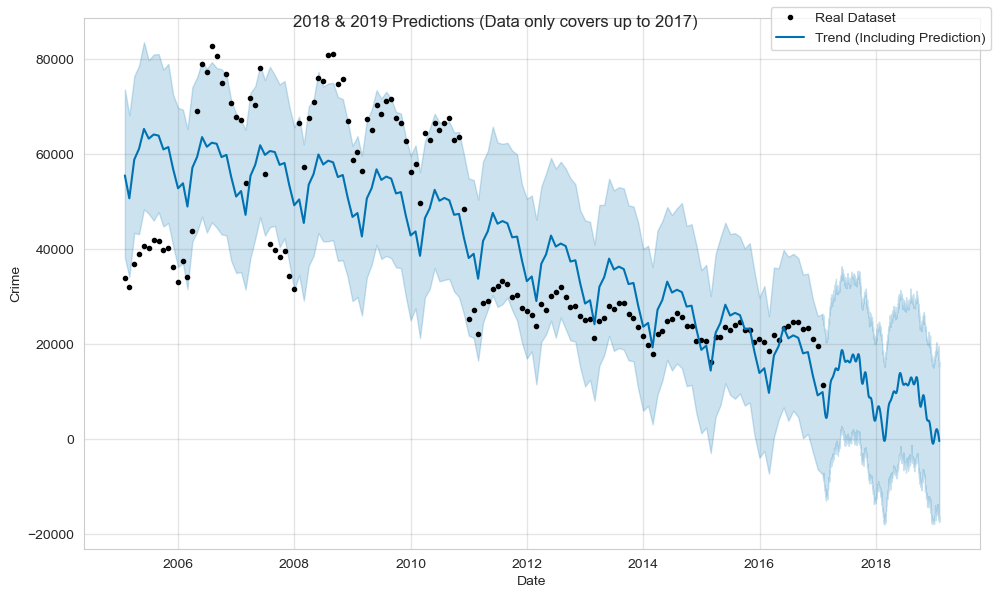

In [85]:
# Show forecast for Crime Rate based on the yearly prediction
figure = meta.plot(forecast, xlabel='Date', ylabel='Crime' )
figure.suptitle('2018 & 2019 Predictions (Data only covers up to 2017)')
figure.legend(['Real Dataset','Trend (Including Prediction)'])

Text(0.5, 1.0, 'Predicted Year 2019 Seasonal Variations')

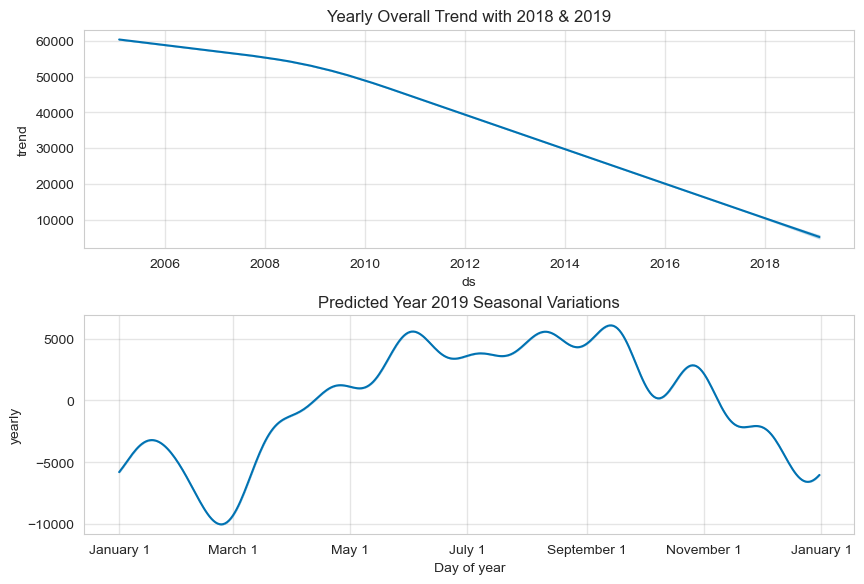

In [76]:
# Plot seasonality
figure = meta.plot_components(forecast)
figure.tight_layout(pad=2)
ax_list = figure.axes
ax_list[0].set_title('Yearly Overall Trend with 2018 & 2019')
ax_list[1].set_title('Predicted Year 2019 Seasonal Variations')